In [119]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import numpy as np
import pandas as pd
pd.set_option('max_rows', 6)
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
# import cmocean.cm as cmo
import csv
import statsmodels.api as sm
from scipy import stats

# mpl.rcParams['mathtext.fontset'] = 'cm'
# mpl.rcParams['mathtext.rm'] = 'serif'

x = "Year CE"
phe = r'$\mathrm{\delta}^{15}$N Phe ('u"\u2030)"
eaa_neaa = ['Phe', 'Thr', 'Ile', 'Leu', 'Val', 'Asx', 'Glx', 'Pro', 'Ala', 'Ser', 'Gly'] # For Essential/Non-Essential ordering
tr_srcaa = ['Glu', 'Asp', 'Ala', 'Ile', 'Leu', 'Pro', 'Val', 'Gly', 'Ser', 'Lys', 'Tyr', 'Phe', 'Thr'] # For Trophic/Source AA ordering
n = r'$\mathrm{\delta}^{15}$N ['u"\u2030]"
c = r'$\mathrm{\delta}^{13}$C ['u"\u2030]"
deg = u'SST [\u00B0C]'

# Import data
path1 = '~/Documents/GitHub/data/schiff_bulk_years_06-17-2020.csv' # 09-04-2019
path2 = '~/Documents/GitHub/data/schiff_bulk_years_jack4907_12-15-2019.csv'
path3 = '~/Documents/GitHub/data/schiff_bulk_years_sav_12-15-2019.csv'
path4 = '~/Documents/GitHub/data/schiff_bulk_years_stetson_12-15-2019.csv'
path5 = '~/Documents/GitHub/data/schiff_bulk_years_sav_12-22-2019.csv'

df = pd.read_csv(path1, comment = '#')
df.rename(columns={"d15n.vs.air": "d15n", "d13c.vs.vpdb": "d13c", "linear.ad" : "yrAD", "coral.id" : "coral", "sample.no." : "sample"}, inplace = True)

# Round yrAD column to make things easier
df.yrAD = df.yrAD.round(0)

# df_jack4684 = df[df.coral == 'jack-4684-bc-unk']
# df_jack4686t1 = df[df.coral == 'jack-4686-bc-d1-t1']

df_stet = df[df.coral == 'stet-4904-bc1-d2']
df_jack4907 = df[df.coral == 'jack-4907-bc1-d3']
df_jack_usgs = df[df.coral == 'jack-4907-bc1-d1']
df_sav = df[df.coral == 'sav-4902-bc1-unk']
df_jack4684 = df[df.coral == 'jack-4684-bc-unk']
df_jack4686 = df[df.coral == 'jack-4686-bc1-d1-t1']
df_jack4686_mill = df[df.coral == 'jack-4686-bc-d1-t1']

print(df)

                    coral sampler  sample  distance..mm.  d15n   d13c  \
0        jack-4907-bc1-d3    john       1          0.032  9.43 -15.24   
1        jack-4907-bc1-d3    john       2          0.064  9.78 -15.38   
2        jack-4907-bc1-d3    john       3          0.096  9.41 -15.14   
...                   ...     ...     ...            ...   ...    ...   
1227  jack-4686-bc1-d1-t1    john     123       5904.000   NaN    NaN   
1228  jack-4686-bc1-d1-t1    john     124       5952.000   NaN    NaN   
1229  jack-4686-bc1-d1-t1    john     125       6000.000   NaN    NaN   

     treatment  perc.n  perc.c  cn.ratio       machine   X  X.1    yrAD  \
0            a     NaN     NaN       2.3  deltaplus xp NaN  NaN  1423.0   
1            a     NaN     NaN       NaN           NaN NaN  NaN  1391.0   
2            a     NaN     NaN       2.7  deltaplus xp NaN  NaN  1361.0   
...        ...     ...     ...       ...           ...  ..  ...     ...   
1227       NaN     NaN     NaN       NaN

## Calculate mean and standard deviation

In [21]:
print(df_jack_usgs)

                coral sampler  sample  distance..mm.  d15n   d13c treatment  \
318  jack-4907-bc1-d1    usgs       1           0.04  9.97 -15.00         a   
319  jack-4907-bc1-d1    usgs       7           0.24  9.43 -15.99         a   
320  jack-4907-bc1-d1    usgs       9           0.37  9.02 -15.16         a   
..                ...     ...     ...            ...   ...    ...       ...   
396  jack-4907-bc1-d1    usgs     212           8.25  7.87 -16.26         a   
397  jack-4907-bc1-d1    usgs     213           8.31  8.12 -16.38         a   
398  jack-4907-bc1-d1    usgs     219           8.71  7.25 -17.06         a   

     perc.n  perc.c  cn.ratio machine   X  X.1    yrAD  Unnamed: 14  
318     NaN     NaN       NaN     NaN NaN  NaN  1516.0        434.0  
319     NaN     NaN       NaN     NaN NaN  NaN  1137.0        813.0  
320     NaN     NaN       NaN     NaN NaN  NaN   891.0       1059.0  
..      ...     ...       ...     ...  ..  ...     ...          ...  
396     NaN     N

In [34]:
df = df

meand15n = np.mean(df['d15n'])
meand13c = np.mean(df['d13c'])
d15n_std1 = np.std(df['d15n'])
d13c_std2 = np.std(df['d13c'])
d15n_max = np.amax(df['d15n'])
d15n_min = np.amin(df['d15n'])

print(meand15n)
print(meand13c)
print(d15n_std1)
print(d13c_std2)
print(d15n_max)
print(d15n_min)

8.969857142857144
-16.07136690647482
0.7206514768044316
0.550752528268393
10.89
7.44


### Calculate Trophic Position based on bulk d15N

In [38]:
# TP = ((d15Nconsumer - d15Nproducer)/3.4) + 1
d15Nprod = 2.1 # Based on communication with Nancy

In [39]:
myfile = '~/Documents/GitHub/data/cleaned_ndata_12-22-2019.csv'
ndata = pd.read_csv(myfile, sep=',') 
# ndata

In [40]:
filter1 = ndata[(ndata['Region'] == 'SEUS') | (ndata['Region'] == 'Gulf of Mexico')]
filter2 = ndata[(ndata['Region'] == 'SEUS')]
ndata = filter2
# ndata

In [41]:
# TP = ((d15Nconsumer - d15Nproducer)/3.4) + 1

ndata['TP_bulk'] = ((ndata['Bulk'] - d15Nprod)/3.4 +1)
# ndata

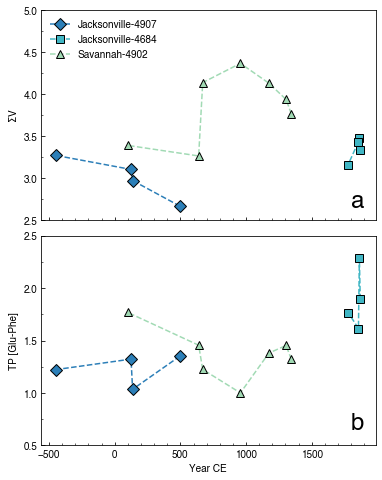

In [85]:
fig, axs = plt.subplots(2, sharex = True, figsize = (6,8),
                       gridspec_kw={'hspace': 0.075})

n_jack = ndata[ndata['Sample ID2']=='Jacksonville-4907']
n_jack2 = ndata[ndata['Sample ID2']=='Jacksonville-4684']
n_sav = ndata[ndata['Sample ID2']=='Savannah Banks-4902']

# SumV
axs[0].plot('Year CE', 'Sum V', data = n_jack, label = "Jacksonville-4907", marker = "D", linestyle = "--", color = "#2c7fb8", markeredgecolor = "k", markersize = markersize)
axs[0].plot('Year CE', 'Sum V', data = n_jack2, label = "Jacksonville-4684", marker = "s", linestyle = "--", color = "#41b6c4", markeredgecolor = "k", markersize = markersize)
axs[0].plot('Year CE', 'Sum V', data = n_sav, label = "Savannah-4902", marker = "^", linestyle = "--", color = "#a1dab4", markeredgecolor = "k", markersize = markersize)

# Trophic position
axs[1].plot('Year CE', 'TP', data = n_jack, label = "", marker = "D", linestyle = "--", color = "#2c7fb8", markeredgecolor = "k", markersize = markersize)
axs[1].plot('Year CE', 'TP', data = n_jack2, label = "", marker = "s", linestyle = "--", color = "#41b6c4", markeredgecolor = "k", markersize = markersize)
axs[1].plot('Year CE', 'TP', data = n_sav, label = "", marker = "^", linestyle = "--", color = "#a1dab4", markeredgecolor = "k", markersize = markersize)

# Legend
axs[0].legend(frameon=False, loc = 2)
# axs[1].legend(frameon=False, loc = 0)

axs[1].set_xlabel("Year CE")
axs[0].set_ylabel(r'$\Sigma$V')
axs[1].set_ylabel('TP [Glu-Phe]')

axs[0].set_ylim(2.5, 5)
axs[1].set_ylim(0.5, 2.5)

xminor = 100
yminor = 0.25

axs[0].xaxis.set_minor_locator(MultipleLocator(xminor))
axs[0].yaxis.set_minor_locator(MultipleLocator(yminor))
axs[1].xaxis.set_minor_locator(MultipleLocator(xminor))
axs[1].yaxis.set_minor_locator(MultipleLocator(yminor))

axs[1].yaxis.set_major_locator(ticker.MaxNLocator(4))

axs[0].tick_params(direction='in', which = 'both')
axs[1].tick_params(direction='in', which = 'both')

style = dict(size=24, color='black', fontweight = 'bold')
axs[0].text(1800, 2.65, 'a', **style)
axs[1].text(1800, 0.65, 'b', **style)

plt.savefig('fig_sumv_tp_through_time.png', dpi = 300, bbox_inches='tight')

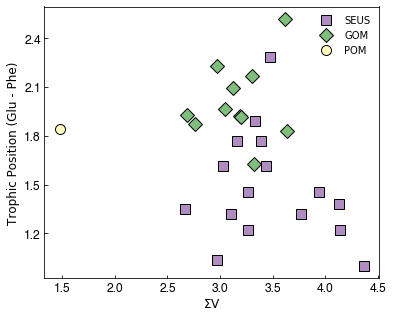

In [5]:
myfile = '~/Documents/GitHub/data/cleaned_ndata_12-22-2019.csv'
corals = pd.read_csv(myfile, sep=',') 
corals = corals[(corals['Region'] == 'SEUS') | (corals['Region'] == 'Gulf of Mexico')]

markersize = 10

seus = corals[corals['Type'] == 'Black Coral - SEUS']
gom = corals[corals['Type'] == 'Black Coral - GOM']
pom = corals[corals['Type'] == 'POM - GOM']

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\Sigma$V', size = 12)
ax.set_ylabel('Trophic Position (Glu - Phe)', size = 12)

plt.plot('Sum V', 'TP', data = seus, label = "SEUS", marker = "s", linestyle = "", color = "#af8dc3", markeredgecolor = "k", markersize = markersize)
ax.tick_params(direction='in', which = 'both')

plt.plot('Sum V', 'TP', data = gom, label = "GOM", marker = "D", linestyle = "", color = "#7fbf7b", markeredgecolor = "k", markersize = markersize)
ax.tick_params(direction='in', which = 'both')

plt.plot('Sum V', 'TP', data = pom, label = "POM", marker = "o", linestyle = "", color = "#ffffbf", markeredgecolor = "k", markersize = markersize)
ax.tick_params(direction='in', which = 'both')
               
# Legend
plt.legend(frameon=False)

# ax.set_ylim(0.5,3)
# ax.set_xlim(2,4.5)
ax.yaxis.set_major_locator(ticker.MaxNLocator(6))

size1 = 12
for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(size1)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(size1)

# Save figure
plt.savefig('fig_tp_sumv_xy.png', dpi=300, bbox_inches='tight')

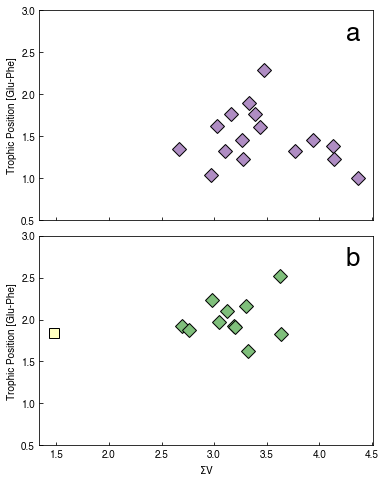

In [116]:
fig, axs = plt.subplots(2, sharex = True, figsize = (6,8),
                       gridspec_kw={'hspace': 0.075})

# SEUS
axs[0].plot('Sum V', 'TP', data = seus, label = "", marker = "D", linestyle = "", color = "#af8dc3", markeredgecolor = "k", markersize = markersize)

# GOM
axs[1].plot('Sum V', 'TP', data = gom, label = "", marker = "D", linestyle = "", color = "#7fbf7b", markeredgecolor = "k", markersize = markersize)
axs[1].plot('Sum V', 'TP', data = pom, label = "", marker = "s", linestyle = "", color = "#ffffbf", markeredgecolor = "k", markersize = markersize)

# Legend
# axs[0].legend(frameon=False, loc = 2)
# axs[1].legend(frameon=False, loc = 0)

axs[1].set_xlabel(r'$\Sigma$V')
axs[0].set_ylabel('Trophic Position [Glu-Phe]')
axs[1].set_ylabel('Trophic Position [Glu-Phe]')

axs[0].set_ylim(0.5,3)
axs[1].set_ylim(0.5,3)

# xminor = 100
# yminor = 0.25

# axs[0].xaxis.set_minor_locator(MultipleLocator(xminor))
# axs[0].yaxis.set_minor_locator(MultipleLocator(yminor))
# axs[1].xaxis.set_minor_locator(MultipleLocator(xminor))
# axs[1].yaxis.set_minor_locator(MultipleLocator(yminor))

# axs[1].yaxis.set_major_locator(ticker.MaxNLocator(4))

axs[0].tick_params(direction='in', which = 'both')
axs[1].tick_params(direction='in', which = 'both')

style = dict(size=26, color='black', fontweight = 'bold')
axs[0].text(4.25, 2.65, 'a', **style)
axs[1].text(4.25, 2.65, 'b', **style)

plt.savefig('fig_sumv_tp_xy.png', dpi = 300, bbox_inches='tight')

In [ ]:
# Subset the data
# NOTE: It is possible to write a for loop to do this, but I am doing this to save time
# https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category

n_jack = ndata[ndata['Sample ID2']=='Jacksonville-4907']
n_jack2 = ndata[ndata['Sample ID2']=='Jacksonville-4684']
n_sav = ndata[ndata['Sample ID2']=='Savannah Banks-4902']
markersize = 8

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax.set_xlabel("Year CE")
# ax.set_ylabel(r'Phe $\mathrm{\delta}^{15}$N ['u"\u2030]")
ax.set_ylabel('TP')

plt.plot('Year CE', 'TP_bulk', data = n_jack, label = "Jacksonville-4907", marker = "D", linestyle = "--", color = "#2c7fb8", markeredgecolor = "k", markersize = markersize)
plt.plot('Year CE', 'TP_bulk', data = n_jack2, label = "Jacksonville-4684", marker = "s", linestyle = "--", color = "#41b6c4", markeredgecolor = "k", markersize = markersize)
plt.plot('Year CE', 'TP_bulk', data = n_sav, label = "Savannah-4902", marker = "^", linestyle = "--", color = "#a1dab4", markeredgecolor = "k", markersize = markersize)

ax.tick_params(direction='in')
               
# Legend
plt.legend(frameon=False)

# Save figure
# plt.savefig('fig_phe_time_2.png', dpi=300, bbox_inches='tight')

In [100]:
gom

,Sample ID,Sample ID2,Type,Region,Bulk,Glu,Asp,Ala,Ile,Leu,...,Lys,Tyr,Phe,Thr,Met,Arg,TP,Sum V,Year CE,yrBP


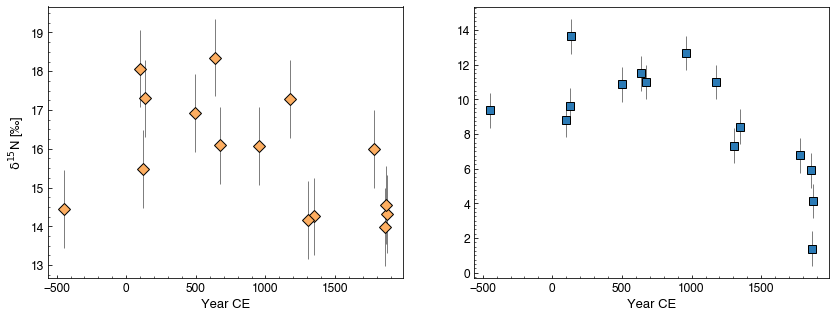

In [47]:
# Subset the data
# NOTE: It is possible to write a for loop to do this, but I am doing this to save time
# https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
mpl.rc('font',family='Helvetica')

markersize = 8

# fig = plt.figure(figsize=(12,5))
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (14,5))
# ax = fig.add_subplot(111)

ndata['error'] = 1

size1 = 13
ax1.set_xlabel("Year CE", size = size1)
ax2.set_xlabel("Year CE", size = size1)
ax1.set_ylabel(n, size = size1)


ax1.plot('Year CE', 'Glu', data = ndata, label = 'Glu (Trophic)',
         marker = "D", linestyle = "None", 
         color = "#fdae61", markeredgecolor = "k", markersize = markersize)
ax1.errorbar(ndata['Year CE'],ndata['Glu'], yerr=[ndata['error'],ndata['error']], fmt='o', color = 'black', linewidth = 0.5, markerfacecolor = 'None', markeredgecolor = 'None')

# axs.subplot(1, 2, 2)
ax2.plot('Year CE', 'Phe', data = ndata, label = 'Phe (Source)',
         marker = "s", linestyle = "None", 
         color = "#2c7bb6", markeredgecolor = "k", markersize = markersize)
ax2.errorbar(ndata['Year CE'],ndata['Phe'], yerr=[ndata['error'],ndata['error']], fmt='o', color = 'black', linewidth = 0.5, markerfacecolor = 'None', markeredgecolor = 'None')


size2 = 12
for tick in ax1.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(size2)
for tick in ax1.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(size2)
    
for tick in ax2.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(size2)
for tick in ax2.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(size2)
    
xminor = 100
yminor = 0.25
ax1.xaxis.set_minor_locator(MultipleLocator(xminor))
ax1.yaxis.set_minor_locator(MultipleLocator(yminor))
ax2.xaxis.set_minor_locator(MultipleLocator(xminor))
ax2.yaxis.set_minor_locator(MultipleLocator(yminor))
ax1.tick_params(direction='in', which = 'both')
ax2.tick_params(direction='in', which = 'both')

# Legend
# ax1.legend(frameon=False, loc = 0)
# ax2.legend(frameon=False, loc = 0)

# Save figure
plt.savefig('fig_phe_glu_time.png', dpi=300, bbox_inches='tight')

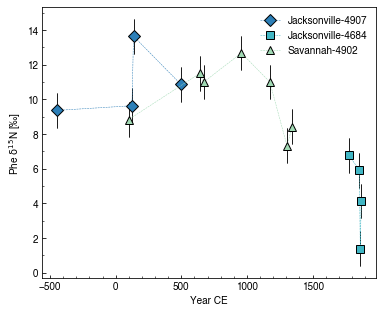

In [52]:
# Subset the data
# NOTE: It is possible to write a for loop to do this, but I am doing this to save time
# https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category

n_jack = ndata[ndata['Sample ID2']=='Jacksonville-4907']
n_jack2 = ndata[ndata['Sample ID2']=='Jacksonville-4684']
n_sav = ndata[ndata['Sample ID2']=='Savannah Banks-4902']
markersize = 8
linewidth = 0.5
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax.set_xlabel("Year CE")
ax.set_ylabel(r'Phe $\mathrm{\delta}^{15}$N ['u"\u2030]")
# ax.set_ylabel('TP')

plt.plot('Year CE', 'Phe', data = n_jack, label = "Jacksonville-4907", marker = "D", linewidth = linewidth, linestyle = "--", color = "#2c7fb8", markeredgecolor = "k", markersize = markersize)
plt.plot('Year CE', 'Phe', data = n_jack2, label = "Jacksonville-4684", marker = "s", linewidth = linewidth, linestyle = "--", color = "#41b6c4", markeredgecolor = "k", markersize = markersize)
plt.plot('Year CE', 'Phe', data = n_sav, label = "Savannah-4902", marker = "^", linewidth = linewidth, linestyle = "--", color = "#a1dab4", markeredgecolor = "k", markersize = markersize)

plt.errorbar(ndata['Year CE'],ndata['Phe'], yerr=[ndata['error'],ndata['error']], fmt='o', color = 'black', linewidth = 0.5, markerfacecolor = 'None', markeredgecolor = 'None')
plt.errorbar(ndata['Year CE'],ndata['Phe'], yerr=[ndata['error'],ndata['error']], fmt='o', color = 'black', linewidth = 0.5, markerfacecolor = 'None', markeredgecolor = 'None')
plt.errorbar(ndata['Year CE'],ndata['Phe'], yerr=[ndata['error'],ndata['error']], fmt='o', color = 'black', linewidth = 0.5, markerfacecolor = 'None', markeredgecolor = 'None')

ax.tick_params(direction='in', which = 'both')
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(1))
               
# Legend
plt.legend(frameon=False)

# Save figure
plt.savefig('fig_phe_time_2.png', dpi=300, bbox_inches='tight')

In [10]:
# df_stet['tp'] = ((df_stet['d15n'] - d15Nprod)/3.4 +1)
# df_stet

In [7]:
# fig, ax = plt.subplots(figsize=(8,6))

# ax.plot('yrAD', 'tp', data=df_stet, color = 'navy', linewidth = 0.5, label = 'Stetson Banks')

# # ax.fill_between(x, y1, y2, facecolor = '#D55E00', interpolate = True, alpha = 0.25)
# ax.tick_params(direction='in')

# ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 17)
# # ax.set_ylabel(n, fontname = 'Helvetica', size = 17)
# ax.set_ylabel('TP', fontname = 'Helvetica', size = 17)

# for tick in ax.get_xticklabels():
#     tick.set_fontname("Helvetica")
#     tick.set_fontsize(17)
# for tick in ax.get_yticklabels():
#     tick.set_fontname("Helvetica")
#     tick.set_fontsize(17)
# # ax.set_xlim(1200, 2010)

# plt.legend(frameon=False, loc=0)
# # plt.savefig('fig_bulk_n_stet_binned.png', dpi = 300, bbox_inches = 'tight')

## Binning time series
This uses a binning function from the Python library Pyleoclim, which is being developed for paleoclimate analysis.

In [2]:
# Using a binning function from Python package Pyleoclim
# Define the function

import numpy as np
import pandas as pd
import warnings
import copy
from scipy import special
import sys
from scipy import signal

def binvalues(x, y, bin_size=None, start=None, end=None):
    """ Bin the values
    Args:
        x (array): the x-axis series.
        y (array): the y-axis series.
        bin_size (float): The size of the bins. Default is the average resolution
        start (float): Where/when to start binning. Default is the minimum
        end (float): When/where to stop binning. Defulat is the maximum
    Returns:
        binned_values - the binned output \n
        bins - the bins (centered on the median, i.e., the 100-200 bin is 150) \n
        n - number of data points in each bin \n
        error -  the standard error on the mean in each bin
    """

    # Make sure x and y are numpy arrays
    x = np.array(x, dtype='float64')
    y = np.array(y, dtype='float64')

    # Get the bin_size if not available
    if bin_size is None:
        bin_size = np.nanmean(np.diff(x))

    # Get the start/end if not given
    if start is None:
        start = np.nanmin(x)
    if end is None:
        end = np.nanmax(x)

    # Set the bin medians
    bins = np.arange(start+bin_size/2, end + bin_size/2, bin_size)

    # Perform the calculation
    binned_values = []
    n = []
    error = []
    for val in np.nditer(bins):
        idx = [idx for idx, c in enumerate(x) if c >= (val-bin_size/2) and c < (val+bin_size/2)]
        if y[idx].size == 0:
            binned_values.append(np.nan)
            n.append(np.nan)
            error.append(np.nan)
        else:
            binned_values.append(np.nanmean(y[idx]))
            n.append(y[idx].size)
            error.append(np.nanstd(y[idx]))

    return bins, binned_values, n, error


## Nitrogen

In [102]:
# Binning
# Jacksonville-4684 BC1
newdf = binvalues(df_jack4684["yrAD"],df_jack4684["d15n"], bin_size = 20)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape

data=newdf
jack4684_binned = pd.DataFrame({'yrAD': data[:, 0], 'd15n': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
jack4684_binned['upper'] = jack4684_binned['d15n'] + jack4684_binned['Column4']
jack4684_binned['lower'] = jack4684_binned['d15n'] - jack4684_binned['Column4']

In [103]:
# Binning
# Jacksonville-4686 BC1, doing something more specific here because samples 123, 124, and 125 were not run on EA-IRMA
# and therefore have missing values

newdf = binvalues(df_jack4686["yrAD"],df_jack4686["d15n"], bin_size = 20)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape

data=newdf
jack4686_binned = pd.DataFrame({'yrAD': data[:, 0], 'd15n': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
jack4686_binned['upper'] = jack4686_binned['d15n'] + jack4686_binned['Column4']
jack4686_binned['lower'] = jack4686_binned['d15n'] - jack4686_binned['Column4']

/Users/jts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice


In [94]:
# df_jack4686 = df_jack4686[['d15n', 'd13c', 'yrAD']]
# df_jack4686

In [105]:
# Binning
# Jacksonville-4907 BC1
newdf = binvalues(df_jack4907["yrAD"],df_jack4907["d15n"], bin_size = 100)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape

data=newdf
jack4907_binned = pd.DataFrame({'yrAD': data[:, 0], 'd15n': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
jack4907_binned['upper'] = jack4907_binned['d15n'] + jack4907_binned['Column4']
jack4907_binned['lower'] = jack4907_binned['d15n'] - jack4907_binned['Column4']

In [120]:
# Savannah-4902 BC1
newdf = binvalues(df_sav['yrAD'],df_sav['d15n'], bin_size = 100)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape
data=newdf
sav_binned = pd.DataFrame({'yrAD': data[:, 0], 'd15n': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
sav_binned['upper'] = sav_binned['d15n'] + sav_binned['Column4']
sav_binned['lower'] = sav_binned['d15n'] - sav_binned['Column4']

In [110]:
# Binning the Stetson-4904 BC1 data
newdf = binvalues(df_stet['yrAD'],df_stet['d15n'], bin_size = 100)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape
data=newdf
stet_binned = pd.DataFrame({'yrAD': data[:, 0], 'd15n': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})

stet_binned['upper'] = stet_binned['d15n'] + stet_binned['Column4']
stet_binned['lower'] = stet_binned['d15n'] - stet_binned['Column4']

In [19]:
# print(jack4907_binned)
# print(sav_binned)
# print(stet_binned)

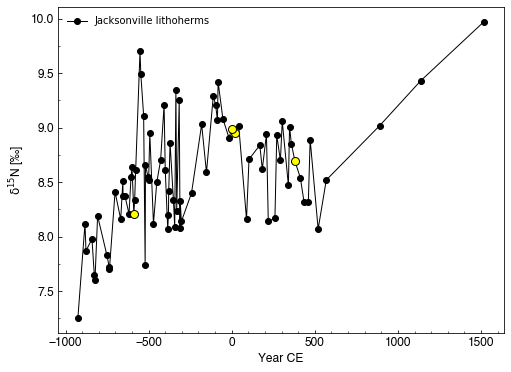

In [22]:
fig, ax = plt.subplots(figsize = (8,6))
data_original = df_jack_usgs
new_df = df_jack_usgs.query('sample == 23')
new_df2 = df_jack_usgs.query('sample == 55')
new_df3 = df_jack_usgs.query('sample == 56')
new_df4 = df_jack_usgs.query('sample == 134')
# data_binned = jack4907_binned

# x = data_binned['yrAD']
# y1 = data_binned['upper']
# y2 = data_binned['lower']

ax.plot('yrAD', 'd15n', data=data_original, color = 'black', linewidth = 1, label = 'Jacksonville lithoherms',
       marker = "o")
# ax.plot('yrAD', 'd15n', data=data_binned, color='#0072B2', linewidth = 3, label = '100-yr average')
# ax.plot(x, y1, x, y2, color = 'darkgray', linewidth=1)
plt.plot('yrAD', 'd15n', data=new_df, 
         label = '_nolegend_',
         color='yellow', marker = "o", markeredgecolor = "black", markersize = 8)
plt.plot('yrAD', 'd15n', data=new_df2, 
         label = '_nolegend_',
         color='yellow', marker = "o", markeredgecolor = "black", markersize = 8)
plt.plot('yrAD', 'd15n', data=new_df3, 
         label = '_nolegend_',
         color='yellow', marker = "o", markeredgecolor = "black", markersize = 8)
plt.plot('yrAD', 'd15n', data=new_df4, 
         label = '_nolegend_',
         color='yellow', marker = "o", markeredgecolor = "black", markersize = 8)


# ax.fill_between(x, y1, y2, facecolor = 'darkgray', interpolate = False)
ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 12)
ax.set_ylabel(n, fontname = 'Helvetica', size = 12)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
    
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(direction='in', which = 'both')
# ax.axhline(y=8.3, color = 'k', linewidth = 1, linestyle = '--')

plt.legend(frameon=False, loc=0)
plt.savefig('fig_bulk_n_jack_usgs.png', dpi = 300, bbox_inches = 'tight')

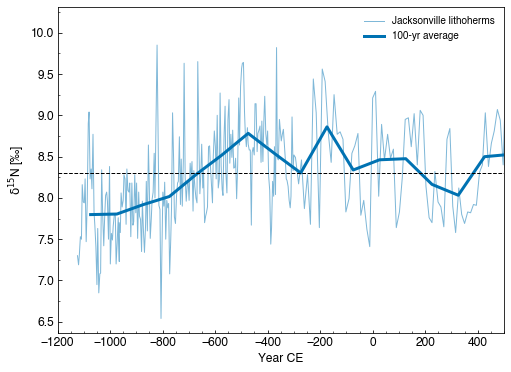

In [40]:
fig, ax = plt.subplots(figsize = (8,6))
data_original = df_jack4907
data_binned = jack4907_binned

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

ax.plot('yrAD', 'd15n', data=data_original, color = '#0072B2', linewidth = 1, label = 'Jacksonville lithoherms', alpha = 0.5)
ax.plot('yrAD', 'd15n', data=data_binned, color='#0072B2', linewidth = 3, label = '100-yr average')
# ax.plot(x, y1, x, y2, color = 'darkgray', linewidth=1)

# ax.fill_between(x, y1, y2, facecolor = 'darkgray', interpolate = False)
ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 12)
ax.set_ylabel(n, fontname = 'Helvetica', size = 12)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
    
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(direction='in', which = 'both')
ax.axhline(y=8.3, color = 'k', linewidth = 1, linestyle = '--')
ax.set_xlim(-1200, 500)

plt.legend(frameon=False, loc=0)
plt.savefig('fig_bulk_n_jack_binned.png', dpi = 300, bbox_inches = 'tight')

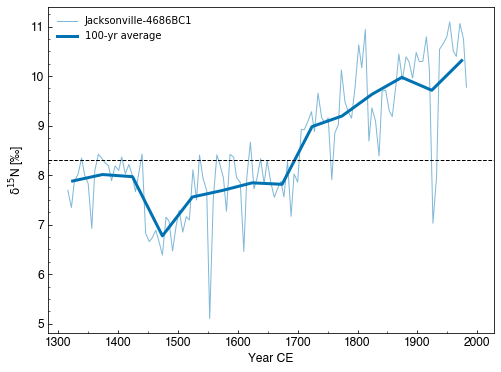

In [19]:
fig, ax = plt.subplots(figsize = (8,6))
data_original = df_jack4686
data_binned = jack4686_binned

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

ax.plot('yrAD', 'd15n', data=data_original, color = '#0072B2', linewidth = 1, label = 'Jacksonville-4686BC1', alpha = 0.5)
ax.plot('yrAD', 'd15n', data=data_binned, color='#0072B2', linewidth = 3, label = '100-yr average')
# ax.plot(x, y1, x, y2, color = 'darkgray', linewidth=1)

# ax.fill_between(x, y1, y2, facecolor = 'darkgray', interpolate = False)
ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 12)
ax.set_ylabel(n, fontname = 'Helvetica', size = 12)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
    
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(direction='in', which = 'both')
ax.axhline(y=8.3, color = 'k', linewidth = 1, linestyle = '--')
# ax.set_xlim(-1200, 500)

plt.legend(frameon=False, loc=0)
# plt.savefig('fig_bulk_n_jack_binned.png', dpi = 300, bbox_inches = 'tight')

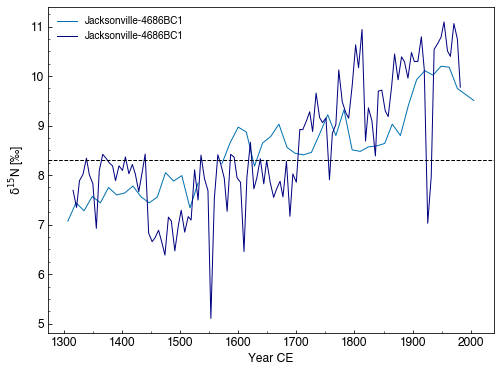

In [113]:
fig, ax = plt.subplots(figsize = (8,6))
data_original = df_jack4686_mill

ax.plot('yrAD', 'd15n', data=data_original, color = '#0072B2', linewidth = 1, label = 'Jacksonville-4686BC1')
ax.plot('yrAD', 'd15n', data=df_jack4686, color = 'navy', linewidth = 1, label = 'Jacksonville-4686BC1')
# ax.plot(x, y1, x, y2, color = 'darkgray', linewidth=1)

ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 12)
ax.set_ylabel(n, fontname = 'Helvetica', size = 12)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
    
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(direction='in', which = 'both')
ax.axhline(y=8.3, color = 'k', linewidth = 1, linestyle = '--')
# ax.set_xlim(-1200, 500)

plt.legend(frameon=False, loc=0)
# plt.savefig('fig_bulk_n_jack_binned.png', dpi = 300, bbox_inches = 'tight')

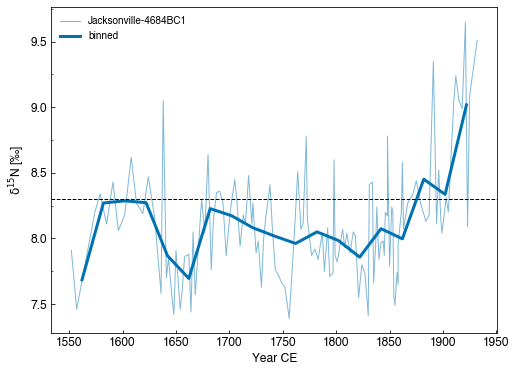

In [115]:
fig, ax = plt.subplots(figsize = (8,6))
data_original = df_jack4684
data_binned = jack4684_binned

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

ax.plot('yrAD', 'd15n', data=data_original, color = '#0072B2', linewidth = 1, label = 'Jacksonville-4684BC1', alpha = 0.5)
ax.plot('yrAD', 'd15n', data=data_binned, color='#0072B2', linewidth = 3, label = 'binned')
# ax.plot(x, y1, x, y2, color = 'darkgray', linewidth=1)

# ax.fill_between(x, y1, y2, facecolor = 'darkgray', interpolate = False)
ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 12)
ax.set_ylabel(n, fontname = 'Helvetica', size = 12)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
    
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(direction='in', which = 'both')
ax.axhline(y=8.3, color = 'k', linewidth = 1, linestyle = '--')
# ax.set_xlim(-1200, 500)

plt.legend(frameon=False, loc=0)
# plt.savefig('fig_bulk_n_jack_binned.png', dpi = 300, bbox_inches = 'tight')

In [8]:
sav_am1 = df_sav

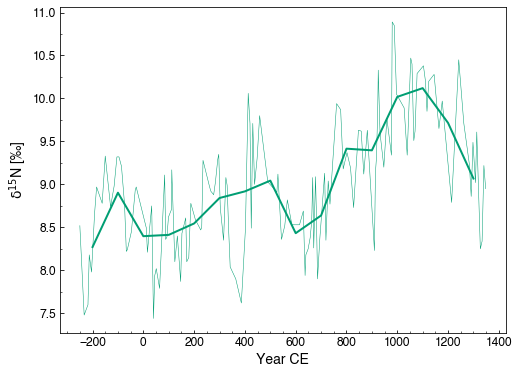

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
data_original = df_sav
data_binned = sav_binned

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

ax.plot('yrAD', 'd15n', data=data_original, color = '#009E73', linewidth = 0.5)
ax.plot('yrAD', 'd15n', data=data_binned, color='#009E73', linewidth = 2)
# ax.plot(x, y1, x, y2, color = 'darkgray', linewidth=1)

# ax.fill_between(x, y1, y2, facecolor = '#1f78b4', interpolate = True, alpha = 0.25)

ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 14)
ax.set_ylabel(n, fontname = 'Helvetica', size = 14)

ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(direction='in', which = 'both')

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)

plt.savefig('fig_bulk_n_sav_binned3.png', dpi = 300, bbox_inches = 'tight')

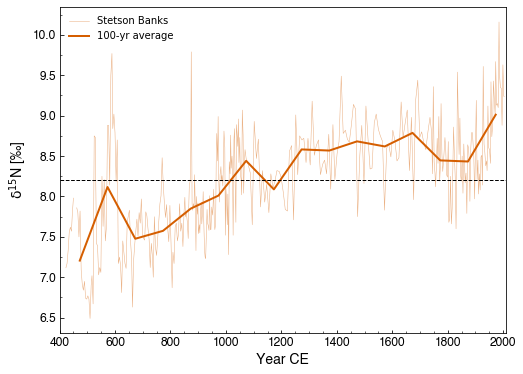

In [23]:
fig, ax = plt.subplots(figsize=(8,6))
data_original = df_stet
data_binned = stet_binned

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

# #D55E00 original color

ax.plot('yrAD', 'd15n', data=data_original, color = '#D55E00', linewidth = 0.5, label = 'Stetson Banks', alpha = 0.5)
ax.plot('yrAD', 'd15n', data=data_binned, color='#D55E00', linewidth = 2, label = '100-yr average') # 'navy' color
# ax.plot(x, y1, x, y2, color = 'darkgray', linewidth=1)

# ax.fill_between(x, y1, y2, facecolor = 'gray', interpolate = True, alpha = 0.25)
ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 14)
ax.set_ylabel(n, fontname = 'Helvetica', size = 14)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
ax.set_xlim(400, 2010)

ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(direction='in', which = 'both')
ax.axhline(y=8.2, color = 'k', linewidth = 1, linestyle = '--')

plt.legend(frameon=False, loc=0)
plt.savefig('fig_bulk_n_stet_binned.png', dpi = 300, bbox_inches = 'tight')

### Combined Nitrogen

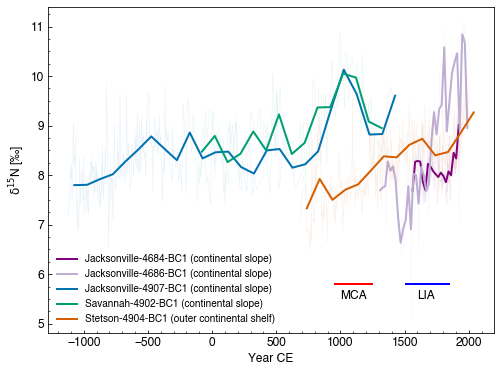

In [121]:
mpl.rc('font',family='Helvetica')

fig, ax = plt.subplots(figsize = (8,6))

alpha = 0.1

# Jacksonville-4684-BC1
x = jack4684_binned['yrAD']
y1 = jack4684_binned['upper']
y2 = jack4684_binned['lower']
ax.plot('yrAD', 'd15n', data=df_jack4684, color = 'purple', linewidth = 0.5, label = '', alpha = alpha)
ax.plot('yrAD', 'd15n', data=jack4684_binned, color='purple', linewidth = 2, label = 'Jacksonville-4684-BC1 (continental slope)')
# ax.fill_between(x, y1, y2, facecolor = 'gray', interpolate = True, alpha = 0.25)

# Jacksonville-4686-BC1
x = jack4686_binned['yrAD']
y1 = jack4686_binned['upper']
y2 = jack4686_binned['lower']
ax.plot('yrAD', 'd15n', data=df_jack4686, color = '#beaed4', linewidth = 0.5, label = '', alpha = alpha)
ax.plot('yrAD', 'd15n', data=jack4686_binned, color='#beaed4', linewidth = 2, label = 'Jacksonville-4686-BC1 (continental slope)')

# # Jacksonville-4686-BC1 MILLED
# ax.plot('yrAD', 'd15n', data=df_jack4686_mill, color = 'navy', linewidth = 1, label = 'Jacksonville-4686BC1')

# Jacksonville-4907
x = jack4907_binned['yrAD']
y1 = jack4907_binned['upper']
y2 = jack4907_binned['lower']
ax.plot('yrAD', 'd15n', data=df_jack4907, color = '#0072B2', linewidth = 0.5, label = '', alpha = alpha)
ax.plot('yrAD', 'd15n', data=jack4907_binned, color='#0072B2', linewidth = 2, label = 'Jacksonville-4907-BC1 (continental slope)')
# ax.fill_between(x, y1, y2, facecolor = 'gray', interpolate = True, alpha = 0.25)
ax.tick_params(direction='in')

# Savannah-4902 BC1
x = sav_binned['yrAD']
y1 = sav_binned['upper']
y2 = sav_binned['lower']
ax.plot('yrAD', 'd15n', data=df_sav, color = '#009E73', linewidth = 0.5, label = '', alpha = alpha)
ax.plot('yrAD', 'd15n', data=sav_binned, color='#009E73', linewidth = 2, label = "Savannah-4902-BC1 (continental slope)")
# ax.fill_between(x, y1, y2, facecolor = '#009E73', interpolate = True, alpha = 0.25)

# Stetson-4904-BC1
x = stet_binned['yrAD']
y1 = stet_binned['upper']
y2 = stet_binned['lower']
ax.plot('yrAD', 'd15n', data=df_stet, color = '#D55E00', linewidth = 0.5, label = '', alpha = alpha)
ax.plot('yrAD', 'd15n', data=stet_binned, color='#D55E00', linewidth = 2, label = 'Stetson-4904-BC1 (outer continental shelf)')
# ax.fill_between(x, y1, y2, facecolor = 'gray', interpolate = True, alpha = 0.25)

ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 12)
ax.set_ylabel(n, fontname = 'Helvetica', size = 12)

ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(direction='in', which = 'both')

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)

plt.legend(frameon=False, loc=0)
ax.hlines(y=5.8, xmin = 950, xmax = 1250, color='r', lw=2)
ax.hlines(y=5.8, xmin = 1500, xmax = 1850, color='b', lw=2)
ax.text(y=5.5, x=1000, s='MCA', fontsize = 12)
ax.text(y=5.5, x=1600, s='LIA', fontsize = 12)

plt.savefig('fig_bulk_n_grouped_binned.png', dpi = 300, bbox_inches='tight')

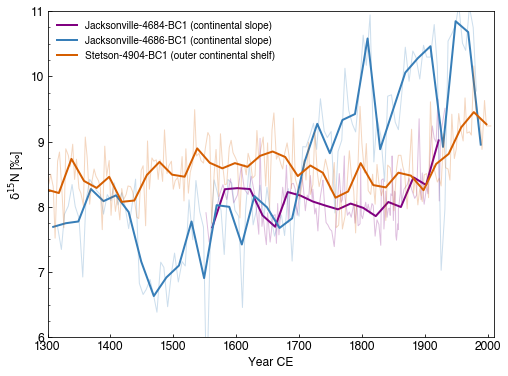

In [109]:
mpl.rc('font',family='Helvetica')

fig, ax = plt.subplots(figsize = (8,6))

# Jacksonville-4684-BC1
x = jack4684_binned['yrAD']
y1 = jack4684_binned['upper']
y2 = jack4684_binned['lower']
ax.plot('yrAD', 'd15n', data=df_jack4684, color = 'purple', linewidth = 1, label = '', alpha = 0.25)
ax.plot('yrAD', 'd15n', data=jack4684_binned, color='purple', linewidth = 2, label = 'Jacksonville-4684-BC1 (continental slope)')
# ax.fill_between(x, y1, y2, facecolor = 'gray', interpolate = True, alpha = 0.25)

# # Jacksonville-4686-BC1
# x = jack4686_binned['yrAD']
# y1 = jack4686_binned['upper']
# y2 = jack4686_binned['lower']
ax.plot('yrAD', 'd15n', data=df_jack4686, color = '#377eb8', linewidth = 1, label = '', alpha = 0.25)
ax.plot('yrAD', 'd15n', data=jack4686_binned, color='#377eb8', linewidth = 2, label = 'Jacksonville-4686-BC1 (continental slope)')

# Stetson-4904-BC1
x = stet_binned['yrAD']
y1 = stet_binned['upper']
y2 = stet_binned['lower']
ax.plot('yrAD', 'd15n', data=df_stet, color = '#D55E00', linewidth = 1, label = '', alpha = 0.25)
ax.plot('yrAD', 'd15n', data=stet_binned, color='#D55E00', linewidth = 2, label = 'Stetson-4904-BC1 (outer continental shelf)')
# ax.fill_between(x, y1, y2, facecolor = 'gray', interpolate = True, alpha = 0.25)

ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 12)
ax.set_ylabel(n, fontname = 'Helvetica', size = 12)
ax.set_xlim(1300,2010)
ax.set_ylim(6,11)

ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(direction='in', which = 'both')

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)

plt.legend(frameon=False, loc=0)
# ax.hlines(y=5.8, xmin = 950, xmax = 1250, color='r', lw=2)
# ax.hlines(y=5.8, xmin = 1500, xmax = 1850, color='b', lw=2)
# ax.text(y=5.5, x=1000, s='MCA', fontsize = 12)
# ax.text(y=5.5, x=1600, s='LIA', fontsize = 12)

plt.savefig('fig_stet_jack4684_jack4686.png', dpi = 300, bbox_inches='tight')

## Carbon

In [62]:
# d13c
# Jacksonville-4907 BC1
data=df_jack4907
newdf = binvalues(data["yrAD"],data["d13c"], bin_size = 100)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape

data=newdf
jack_binned_c = pd.DataFrame({'yrAD': data[:, 0], 'd13c': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
jack_binned_c['upper'] = jack_binned_c['d13c'] + jack_binned_c['Column4']
jack_binned_c['lower'] = jack_binned_c['d13c'] - jack_binned_c['Column4']

In [65]:
# Binning
# Jacksonville-4686 BC1, doing something more specific here because samples 123, 124, and 125 were not run on EA-IRMA
# and therefore have missing values
data = df_jack4686
newdf = binvalues(data["yrAD"],data["d13c"], bin_size = 50)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape

data=newdf
jack4686_binned_c = pd.DataFrame({'yrAD': data[:, 0], 'd13c': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
jack4686_binned_c['upper'] = jack4686_binned_c['d13c'] + jack4686_binned_c['Column4']
jack4686_binned_c['lower'] = jack4686_binned_c['d13c'] - jack4686_binned_c['Column4']

In [66]:
# d13c
# Savannah-4902 BC1
data=df_sav
newdf = binvalues(data["yrAD"],data["d13c"], bin_size = 100)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape

data=newdf
sav_binned_c = pd.DataFrame({'yrAD': data[:, 0], 'd13c': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
sav_binned_c['upper'] = sav_binned_c['d13c'] + sav_binned_c['Column4']
sav_binned_c['lower'] = sav_binned_c['d13c'] - sav_binned_c['Column4']

In [67]:
# d13c
# Stetson-4904 BC1
data=df_stet
newdf = binvalues(data["yrAD"],data["d13c"], bin_size = 100)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape

data=newdf
stet_binned_c = pd.DataFrame({'yrAD': data[:, 0], 'd13c': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
stet_binned_c['upper'] = stet_binned_c['d13c'] + stet_binned_c['Column4']
stet_binned_c['lower'] = stet_binned_c['d13c'] - stet_binned_c['Column4']

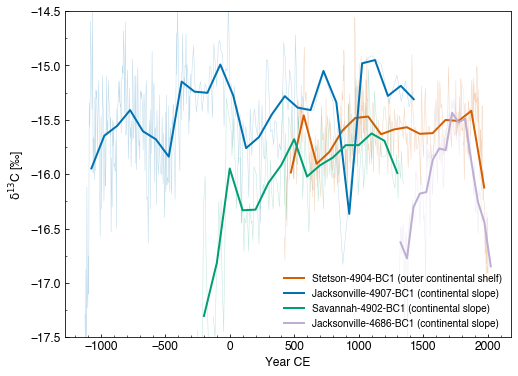

In [68]:
mpl.rc('font',family='Helvetica')

fig, ax = plt.subplots(figsize = (8,6))

# Stetson-4904
x = stet_binned_c['yrAD']
y1 = stet_binned_c['upper']
y2 = stet_binned_c['lower']
ax.plot('yrAD', 'd13c', data=df_stet, color = '#D55E00', linewidth = 0.5, alpha = 0.25, label = '')
ax.plot('yrAD', 'd13c', data=stet_binned_c, color='#D55E00', linewidth = 2, label = 'Stetson-4904-BC1 (outer continental shelf)')
# ax.fill_between(x, y1, y2, facecolor = '#D55E00', interpolate = True, alpha = 0.25)

# Jacksonville-4907

x = jack_binned_c['yrAD']
y1 = jack_binned_c['upper']
y2 = jack_binned_c['lower']
ax.plot('yrAD', 'd13c', data=df_jack4907, color = '#0072B2', linewidth = 0.5, alpha = 0.25, label = '')
ax.plot('yrAD', 'd13c', data=jack_binned_c, color='#0072B2', linewidth = 2, label = 'Jacksonville-4907-BC1 (continental slope)')
# ax.fill_between(x, y1, y2, facecolor = '#0072B2', interpolate = False, alpha = 0.25)

# Savannah-4902 BC1
x = sav_binned_c['yrAD']
y1 = sav_binned_c['upper']
y2 = sav_binned_c['lower']
ax.plot('yrAD', 'd13c', data=df_sav, color = '#009E73', linewidth = 0.5, alpha = 0.25, label = '')
ax.plot('yrAD', 'd13c', data=sav_binned_c, color='#009E73', linewidth = 2, label = 'Savannah-4902-BC1 (continental slope)')
# ax.fill_between(x, y1, y2, facecolor = '#1f78b4', interpolate = True, alpha = 0.25)

# Jacksonville-4686-BC1
x = jack4686_binned_c['yrAD']
y1 = jack4686_binned_c['upper']
y2 = jack4686_binned_c['lower']
ax.plot('yrAD', 'd13c', data=df_jack4686, color = '#beaed4', linewidth = 0.5, label = '', alpha = 0.25)
ax.plot('yrAD', 'd13c', data=jack4686_binned_c, color='#beaed4', linewidth = 2, label = 'Jacksonville-4686-BC1 (continental slope)')

ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 12)
ax.set_ylabel(c, fontname = 'Helvetica', size = 12)
ax.set_ylim(-17.5, -14.5)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)

ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(direction='in', which = 'both') 

plt.legend(frameon=False, loc=0)
plt.savefig('fig_bulk_c_jack_stet_sav_binned.png', dpi = 300, bbox_inches='tight')

In [83]:
stet_binned_c

,yrAD,d13c,Column3,Column4,upper,lower
0,498.0,-15.909734,29.0,0.361206,-15.548528,-16.270939
1,598.0,-15.600000,31.0,0.354383,-15.245617,-15.954383
2,698.0,-15.798750,32.0,0.229371,-15.569379,-16.028121
...,...,...,...,...,...,...
13,1798.0,-15.520800,25.0,0.203429,-15.317371,-15.724229
14,1898.0,-15.466667,27.0,0.276271,-15.190395,-15.742938
15,1998.0,-16.490588,17.0,0.346418,-16.144170,-16.837006


### Stetson Banks bulk d13C record

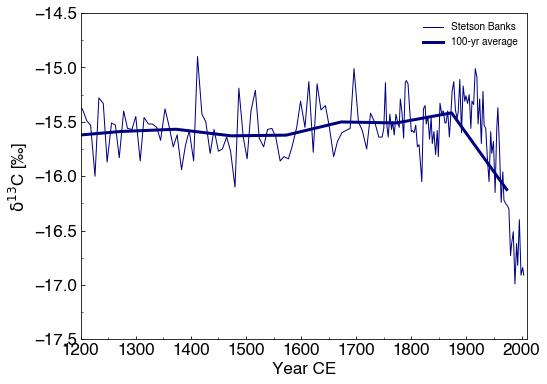

In [72]:
fig, ax = plt.subplots(figsize=(8,6))
data_original = df_stet
data_binned = stet_binned_c

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

# color: #D55E00

ax.plot('yrAD', 'd13c', data=data_original, color = 'navy', linewidth = 1, label = 'Stetson Banks')
ax.plot('yrAD', 'd13c', data=data_binned, color='navy', linewidth = 3, label = '100-yr average')
# ax.fill_between(x, y1, y2, facecolor = '#D55E00', interpolate = True, alpha = 0.25)
ax.tick_params(direction='in')

ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 17)
ax.set_ylabel(c, fontname = 'Helvetica', size = 17)
ax.set_ylim(-17.5, -14.5)
ax.set_xlim(1200, 2010)

msize = 18
col = '#F0E442'
outline = 'k'
marker = '*'
# plt.plot(data_original['yrAD'][6], data_original['d13c'][6], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][7], data_original['d13c'][7], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][21], data_original['d13c'][21], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][24], data_original['d13c'][24], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][39], data_original['d13c'][39], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][45], data_original['d13c'][45], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][45], data_original['d13c'][45], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][102], data_original['d13c'][102], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][108], data_original['d13c'][108], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][134], data_original['d13c'][134], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][169], data_original['d13c'][169], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(17)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(17)
    
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(direction='in', which = 'both') 
    
plt.legend(frameon=False, loc=0)
plt.savefig('fig_bulk_c_stet_binned-recent.png', dpi = 300, bbox_inches = 'tight')

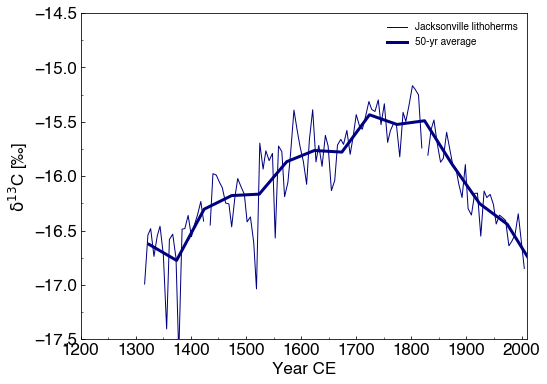

In [74]:
fig, ax = plt.subplots(figsize=(8,6))
data_original = df_jack4686
data_binned = jack4686_binned_c

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

# color: #D55E00

ax.plot('yrAD', 'd13c', data=data_original, color = 'navy', linewidth = 1, label = 'Jacksonville lithoherms')
ax.plot('yrAD', 'd13c', data=data_binned, color='navy', linewidth = 3, label = '50-yr average')
# ax.fill_between(x, y1, y2, facecolor = '#D55E00', interpolate = True, alpha = 0.25)
ax.tick_params(direction='in')

ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 17)
ax.set_ylabel(c, fontname = 'Helvetica', size = 17)
ax.set_ylim(-17.5, -14.5)
ax.set_xlim(1200, 2010)

msize = 18
col = '#F0E442'
outline = 'k'
marker = '*'
# plt.plot(data_original['yrAD'][6], data_original['d13c'][6], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][7], data_original['d13c'][7], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][21], data_original['d13c'][21], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][24], data_original['d13c'][24], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][39], data_original['d13c'][39], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][45], data_original['d13c'][45], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][45], data_original['d13c'][45], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][102], data_original['d13c'][102], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][108], data_original['d13c'][108], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][134], data_original['d13c'][134], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][169], data_original['d13c'][169], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(17)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(17)
    
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(direction='in', which = 'both') 
    
plt.legend(frameon=False, loc=0)
# plt.savefig('fig_bulk_c_stet_binned-recent.png', dpi = 300, bbox_inches = 'tight')

In [14]:
data_original

,Unnamed: 0,coral,sampler,sample.no.,distance..mm.,d15n,d13c,treatment,perc.n,perc.c,cn.ratio,machine,X,X.1,yrAD
0,1,stet-4904-bc1-d2,john,1,0.001,9.240000,-16.910000,a,NaN,NaN,NaN,NaN,NaN,NaN,2004
1,2,stet-4904-bc1-d2,john,2,0.031,9.240000,-16.840000,a,NaN,NaN,NaN,NaN,NaN,NaN,2002
2,3,stet-4904-bc1-d2,john,3,0.061,9.630000,-16.910000,b,NaN,NaN,NaN,delta v plus,NaN,NaN,1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,384,stet-4904-bc1-d2,john,384,11.491,7.330000,-16.390000,a,NaN,NaN,NaN,delta v plus,NaN,NaN,431
384,385,stet-4904-bc1-d2,john,385,11.521,7.170000,-16.790000,a,NaN,NaN,NaN,delta v plus,NaN,NaN,427
385,386,stet-4904-bc1-d2,john,386,11.551,7.118105,-16.582813,NaN,NaN,NaN,2.95,delta v plus,NaN,NaN,423


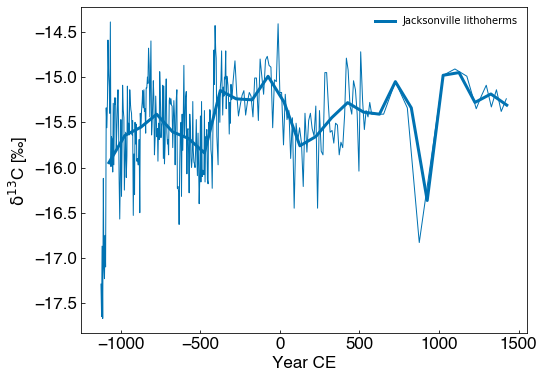

In [10]:
fig, ax = plt.subplots(figsize = (8,6))
data_original = df_jack4907
data_binned = jack_binned_c

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

ax.plot('yrAD', 'd13c', data=data_original, color = '#0072B2', linewidth = 1, label = '')
ax.plot('yrAD', 'd13c', data=data_binned, color='#0072B2', linewidth = 3, label = 'Jacksonville lithoherms')
# ax.plot(x, y1, x, y2, color = 'darkgray', linewidth=1)

# ax.fill_between(x, y1, y2, facecolor = 'darkgray', interpolate = True, alpha = 0.5)

ax.tick_params(direction='in')

ax.set_xlabel("Year CE", size = 17, fontname = 'Helvetica')
ax.set_ylabel(c, size = 17, fontname = 'Helvetica')

# ax.set_xlim(-50, 1400)


for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(17)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(17)

plt.legend(frameon=False, loc=0)
plt.savefig('fig_bulk_c_jack_binned3.png', dpi = 300, bbox_inches = 'tight')

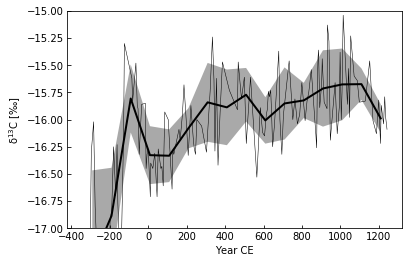

In [127]:
fig, ax = plt.subplots()
data_original = df_sav
data_binned = sav_binned_c

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

ax.plot('yrAD', 'd13c', data=data_original, color = 'k', linewidth = 0.5)
ax.plot('yrAD', 'd13c', data=data_binned, color='k', linewidth = 2)
# ax.plot(x, y1, x, y2, color = 'darkgray', linewidth=1)

ax.fill_between(x, y1, y2, facecolor = 'darkgray', interpolate = True)

ax.tick_params(direction='in')

ax.set_xlabel("Year CE")
ax.set_ylabel(c)

# ax.set_xlim(-50, 1400)
ax.set_ylim(-17, -15)

# ax.set_xlim(0, max(df_sav['yrAD']))

plt.savefig('fig_bulk_c_sav_binned2.png', dpi = 300, bbox_inches = 'tight')

### Carbon and Nitrogen stacked plot

NameError: name 'jack4907_binned' is not defined

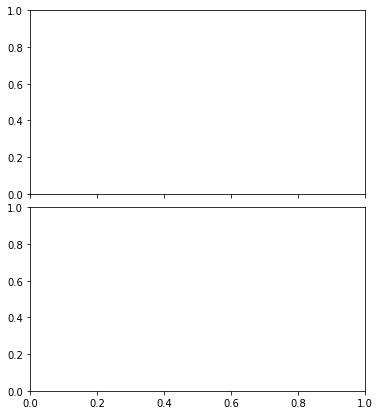

In [15]:
fig, axs = plt.subplots(2, sharex=True, figsize = (6,7), 
                       gridspec_kw={'hspace': 0.075})

binned_n = jack4907_binned
binned_c = jack_binned_c
data_orig = df_jack4907

x = binned_c['yrAD']
y1 = binned_c['upper']
y2 = binned_c['lower']
axs[0].plot('yrAD', 'd13c', data=data_orig, color = '#016c59', linewidth = 0.5, alpha = 0.5)
axs[0].plot('yrAD', 'd13c', data=binned_c, color='#016c59', linewidth = 1.25)
axs[0].fill_between(x, y1, y2, facecolor = '#016c59', interpolate = False, alpha = 0.25)

x = binned_n['yrAD']
y1 = binned_n['upper']
y2 = binned_n['lower']
axs[1].plot('yrAD', 'd15n', data=data_orig, color = '#0072B2', linewidth = 0.5, label = '', alpha = 0.5)
axs[1].plot('yrAD', 'd15n', data=binned_n, color='#0072B2', linewidth = 1.25, label = 'Jacksonville-4907 BC1')
axs[1].fill_between(x, y1, y2, facecolor = '#0072B2', interpolate = False, alpha = 0.25)

axs[0].set_ylabel(c, fontname = 'Helvetica')
axs[1].set_ylabel(n, fontname = 'Helvetica')
axs[1].set_xlabel('Year CE', fontname = 'Helvetica')

axs[0].set_ylim(-17,-14.5)

axs[0].tick_params(direction='in')
axs[1].tick_params(direction='in')

for tick in axs[0].get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in axs[0].get_yticklabels():
    tick.set_fontname("Helvetica")
    
for tick in axs[1].get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in axs[1].get_yticklabels():
    tick.set_fontname("Helvetica")

plt.savefig('fig_bulk_jack_combined.png', dpi = 300, bbox_inches='tight')

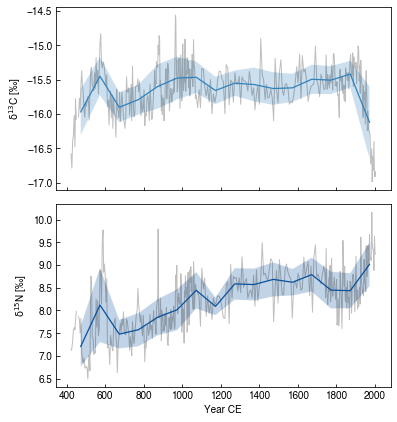

In [30]:
fig, axs = plt.subplots(2, sharex=True, figsize = (6,7), 
                       gridspec_kw={'hspace': 0.075})

binned_n = stet_binned
binned_c = stet_binned_c
data_orig = df_stet

x = binned_c['yrAD']
y1 = binned_c['upper']
y2 = binned_c['lower']
axs[0].plot('yrAD', 'd13c', data=data_orig, color = 'k', linewidth = 1, alpha = 0.25)
axs[0].plot('yrAD', 'd13c', data=binned_c, color='#3182bd', linewidth = 1.25)
axs[0].fill_between(x, y1, y2, facecolor = '#3182bd', interpolate = False, alpha = 0.25)

x = binned_n['yrAD']
y1 = binned_n['upper']
y2 = binned_n['lower']
axs[1].plot('yrAD', 'd15n', data=data_orig, color = 'k', linewidth = 1, alpha = 0.25)
axs[1].plot('yrAD', 'd15n', data=binned_n, color='#08519c', linewidth = 1.25, label = 'Stetson-4904 BC1')
axs[1].fill_between(x, y1, y2, facecolor = '#08519c', interpolate = False, alpha = 0.25)

axs[0].set_ylabel(c, fontname = 'Helvetica')
axs[1].set_ylabel(n, fontname = 'Helvetica')
axs[1].set_xlabel('Year CE', fontname = 'Helvetica')

# axs[0].set_ylim(-17,-14.5)

for tick in axs[0].get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in axs[0].get_yticklabels():
    tick.set_fontname("Helvetica")
    
for tick in axs[1].get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in axs[1].get_yticklabels():
    tick.set_fontname("Helvetica")

axs[0].tick_params(direction='in')
axs[1].tick_params(direction='in')

plt.savefig('fig_bulk_stet_combined.png', dpi = 300, bbox_inches='tight')

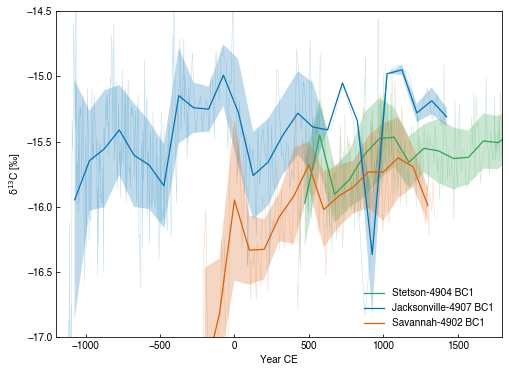

In [54]:
import matplotlib.font_manager as font_manager

fig, ax = plt.subplots(figsize = (8,6))

# Stetson-4904
x = stet_binned_c['yrAD']
y1 = stet_binned_c['upper']
y2 = stet_binned_c['lower']
ax.plot('yrAD', 'd13c', data=df_stet, color = '#31a354', linewidth = 0.5, label = '', alpha = 0.25)
ax.plot('yrAD', 'd13c', data=stet_binned_c, color='#31a354', linewidth = 1.25, label = 'Stetson-4904 BC1')
ax.fill_between(x, y1, y2, facecolor = '#31a354', interpolate = True, alpha = 0.25)

# Jacksonville-4907
x = jack_binned_c['yrAD']
y1 = jack_binned_c['upper']
y2 = jack_binned_c['lower']
ax.plot('yrAD', 'd13c', data=df_jack4907, color = '#0072B2', linewidth = 0.5, label = '', alpha = 0.25)
ax.plot('yrAD', 'd13c', data=jack_binned_c, color='#0072B2', linewidth = 1.25, label = 'Jacksonville-4907 BC1')
ax.fill_between(x, y1, y2, facecolor = '#0072B2', interpolate = False, alpha = 0.25)
ax.tick_params(direction='in')

# Savannah-4902
x = sav_binned_c['yrAD']
y1 = sav_binned_c['upper']
y2 = sav_binned_c['lower']
ax.plot('yrAD', 'd13c', data=df_sav, color = '#d95f0e', linewidth = 0.5, label = '', alpha = 0.25)
ax.plot('yrAD', 'd13c', data=sav_binned_c, color='#d95f0e', linewidth = 1.25, label = 'Savannah-4902 BC1')
ax.fill_between(x, y1, y2, facecolor = '#d95f0e', interpolate = False, alpha = 0.25)
ax.tick_params(direction='in')

ax.set_xlabel("Year CE", fontname = 'Helvetica')
ax.set_ylabel(c, fontname = 'Helvetica')

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")

ax.set_ylim(-17,-14.5)
ax.set_xlim(-1200,1800)

font = font_manager.FontProperties(family='Helvetica')

plt.legend(frameon=False, loc=0, prop = font)

plt.savefig('fig_bulk_c_grouped_binned.png', dpi = 300, bbox_inches='tight')

In [6]:
df_bam = pd.read_csv('~/Documents/GitHub/data/schiff_jack4907 bam1 by treatment.csv', comment = '#')
df_bam

,Unnamed: 0,Distance,Treatment,d15N,d13C
0,63,0.17,a,9.480567,-17.654419
1,64,0.34,a,8.871778,-16.927011
2,65,0.51,a,9.242476,-16.934112
...,...,...,...,...,...
89,524,4.76,o,9.000473,-16.187885
90,525,4.93,o,9.083220,-15.718482
91,526,5.10,o,9.680609,-16.403114


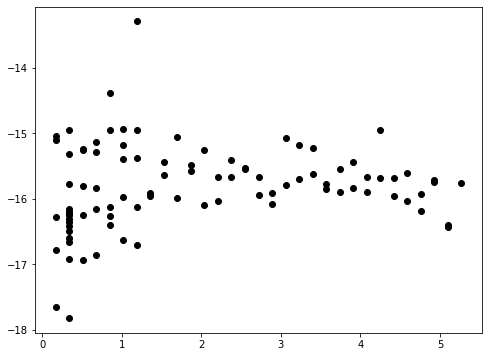

In [10]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot('Distance', 'd13C', data = df_bam, marker = "o", color = "black", linewidth = 0)

In [11]:
meand15n = np.mean(df_bam['d15N'])
meand13c = np.mean(df_bam['d13C'])
d15n_std1 = np.std(df_bam['d15N'])
d13c_std2 = np.std(df_bam['d13C'])
d15n_max = np.amax(df_bam['d15N'])
d15n_min = np.amin(df_bam['d15N'])

print(meand15n)
print(meand13c)
print(d15n_std1)
print(d13c_std2)
print(d15n_max)
print(d15n_min)

8.867960766315218
-15.817331516956516
0.49067424889903133
0.6451420257906522
10.35432286
7.469664438
